## Laboratoire 2
**Equipe 1** 



**Membres:**


## Introduction

 Pour ce laboratoire, nous devons choisir 8 classes pour créer un ensemble d'images qui pourront être reconnu grâce aux notions que nous avons apprisent en classe.
 Pour ce faire, nous utiliserons Jupyter Notebook afin de séparer clairement chacune des étapes que nous deverons accomplir.
 Nous allons faire par nous même un réseau de neuronne et par la suite, utiliser des modeles déjà existant afin de comparer nos résultats. Ceci nous permettera de tirer une conclusion sur les forces et faiblesses de différents modèles.
 

## Importation des librairies nécéssaires

Les librairies qui nous seront nécéssaire pour le traitement des images sont les suivantes :


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neural_network import MLPClassifier

## Augmentation des données

## Choix du Dataset pour l'ensemble B

Voici notre choix d'images pour l'ensemble B. Cet ensemble est constitué de 8 symboles:

In [2]:
# Define the base data directory path
data_dir = Path.cwd() / "EnsembleB_H2020"

# A list of string with all the categories/labels in your database, i.e., each class subfolder name
CLASSES = [
    {
        "LABEL": "Cercle2", 
        "GROUP": 0,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle2')
    },
    {
        "LABEL": "Cercle3", 
        "GROUP": 1,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle3')
    },
    {
        "LABEL": "Diamant2",
        "GROUP": 2,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant2')
    },
    {
        "LABEL":"Diamant3", 
        "GROUP": 3,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant3')
    },
    {
        "LABEL":"Hexagone2", 
        "GROUP": 4,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone2')
    },
    {
        "LABEL":"Hexagone3", 
        "GROUP": 5,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone3')
    },
    {
        "LABEL":"Triangle2", 
        "GROUP": 6,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle3", 
        "GROUP": 7,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle3')
    }
]

## Pretraitement des images

Nous avons commencé par redimmensionner les images, pour ensuite leur appliqué un filtre pour les rendre grises et pour les rendre flous. Les opérations qui nous ont permi d'avoir le plus d'amélioration selon nos test était l'application du filtre pour le flou et du filtre pour le gris. 

In [3]:
imageSize = (160, 160)

dataSet = []

# Read all the files and append to dataset
for CLASS in CLASSES:
    print(f"=> Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        gray = cv2.resize(gray, imageSize)
        
        # Calculate contours
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        # Save the polygons
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            polygons.append(len(approximation))
        
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # Create a data variable to add to dataSet
        data = {
            'image': gray,
            'label': CLASS['GROUP'],
            'polygons': polygons,
            'feature': feature
        }
        
        # Append data to dataSet
        dataSet.append(data)   

=> Reading files from class Cercle2



=> Reading files from class Cercle3



=> Reading files from class Diamant2



=> Reading files from class Diamant3



=> Reading files from class Hexagone2



=> Reading files from class Hexagone3



=> Reading files from class Triangle2



=> Reading files from class Triangle3


In [4]:
# Shuffles the images
random.shuffle(dataSet)

# create the X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating the files containing all the information about your model and saving them to the disk
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Machine learning training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [7]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [8]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Réseau Neuronal

Voici notre modèle pour le Réseau Neuronal. Nous nous sommes basé sur la théorie vue en classe pour le faire. Une fois le modèle en place, nous avons essayer avec des hyperparamètres différents tel qu'un learning rate ou un nombre d'itérations (epoch) plus ou moins élevé. Nous avons laissé comme données les hyperparamètre pour lesquels nous semblions avoir le plus de succès.

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

In [10]:
class NeuralNetwork:

    def __init__(self, n_classes, n_features, n_hidden_units=15, epochs=300,
                 learning_rate=0.01, n_batches=1):
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def error(self, y, output):
        error = -np.sum(y*np.log(output))
        return 0.5 * np.mean(error)

    def weights(self):
        w1 = np.random.rand(self.n_hidden_units, self.n_features)
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)
        return w1, w2

    def forward(self, X):
        z1 = np.dot(self.w1,X.T)
        hidden_output = sigmoid(z1)
        z2 = np.dot(self.w2,hidden_output)
        final_output = sigmoid(z2)
        return z1, hidden_output, z2, final_output

    def backward(self, X, z1, hidden_output, final_output, y):
        output_error = final_output - y
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)
        grad1 = output_delta.dot(X)
        grad2 = output_error.dot(hidden_output.T)
        return grad1, grad2

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward(X)
        y = y.T
        grad1, grad2 = self.backward(X, z1, hidden_output, final_output, y)
        error = self.error(y, final_output)
        return error, grad1, grad2

    def fit(self, X, y):
        self.error_ = []
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)

        X_batches = np.array_split(X, self.n_batches)
        y_batches = np.array_split(y, self.n_batches)

        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_batches, y_batches):
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self

    def predict(self, X):
        z1, hidden_output, z2, final_output = self.forward(X)
        return np.argmax(z2.T, 1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [11]:
nn = NeuralNetwork(
    n_classes=8, 
    n_features=len(X[0]),
    n_hidden_units=50,
    epochs=3000,
    learning_rate=0.01,
    n_batches=30,
).fit(X_train, y_train);

0 22.70522519805485
1 26.845213339937057
2 26.67178801283415
3 26.493625685498888
4 26.30866927808057
5 26.11540729283121
6 25.912917699388174
7 25.70092167228359
8 25.479827741884193
9 25.250745140807876
10 25.015446649099676
11 24.77626784473902
12 24.535941715586926
13 24.29738298968567
14 24.06345075697094
15 23.836725619651194
16 23.61933524265294
17 23.412850357690743
18 23.21825656126576
19 23.035991729034592
20 22.86602909402153
21 22.707983347133684
22 22.561220054818175
23 22.424954549847143
24 22.29833275610423
25 22.180491608772183
26 22.070600241973718
27 21.967885009038305
28 21.87164206051882
29 21.781241078873578
30 21.696123234610354
31 21.615795752758604
32 21.539824820559414
33 21.467828006116477
34 21.399466919362066
35 21.334440526914083
36 21.2724793130021
37 21.213340337162368
38 21.15680315451137
39 21.10266651828965
40 21.05074576337567
41 21.000870763845356
42 20.952884360845566
43 20.906641164927837
44 20.862006647109467
45 20.818856443936888
46 20.7770758130

388 16.68807521522262
389 16.67925981125266
390 16.67045346695712
391 16.661656389052332
392 16.652868785007783
393 16.644090862913483
394 16.635322831347555
395 16.626564899244205
396 16.617817275762373
397 16.609080170155043
398 16.600353791639456
399 16.591638349268386
400 16.582934051802532
401 16.574241107584314
402 16.565559724413028
403 16.556890109421648
404 16.548232468955305
405 16.539587008451594
406 16.530953932322838
407 16.522333443840417
408 16.51372574502121
409 16.50513103651638
410 16.49654951750246
411 16.487981385574898
412 16.47942683664419
413 16.470886064834563
414 16.462359262385416
415 16.453846619555488
416 16.445348324529878
417 16.436864563329934
418 16.428395519726116
419 16.419941375153837
420 16.411502308632347
421 16.40307849668669
422 16.394670113272767
423 16.38627732970555
424 16.377900314590462
425 16.369539233757905
426 16.36119425020103
427 16.352865524016654
428 16.344553212349435
429 16.336257469339223
430 16.3279784460716
431 16.319716290531638


775 14.359182177080864
776 14.354929643798936
777 14.350682239052803
778 14.346439965620728
779 14.34220282610039
780 14.337970822902273
781 14.333743958243321
782 14.329522234140986
783 14.32530565240758
784 14.321094214644988
785 14.316887922239676
786 14.312686776358074
787 14.308490777942241
788 14.304299927705886
789 14.30011422613067
790 14.295933673462867
791 14.291758269710284
792 14.287588014639507
793 14.283422907773438
794 14.279262948389125
795 14.27510813551587
796 14.270958467933603
797 14.266813944171561
798 14.262674562507152
799 14.258540320965162
800 14.254411217317182
801 14.250287249081206
802 14.24616841352156
803 14.242054707648979
804 14.23794612822095
805 14.233842671742202
806 14.229744334465476
807 14.225651112392391
808 14.22156300127458
809 14.217479996614925
810 14.213402093669009
811 14.209329287446712
812 14.205261572713926
813 14.201198943994473
814 14.197141395572089
815 14.193088921492599
816 14.18904151556613
817 14.18499917136955
818 14.1809618822488

1164 12.994599826575445
1165 12.991519415104214
1166 12.988439949574985
1167 12.985361426030602
1168 12.982283840568517
1169 12.97920718934035
1170 12.97613146855145
1171 12.973056674460464
1172 12.969982803378828
1173 12.96690985167036
1174 12.963837815750786
1175 12.960766692087264
1176 12.957696477197912
1177 12.954627167651358
1178 12.951558760066243
1179 12.94849125111075
1180 12.945424637502128
1181 12.942358916006189
1182 12.939294083436842
1183 12.936230136655599
1184 12.93316707257106
1185 12.93010488813846
1186 12.927043580359138
1187 12.923983146280044
1188 12.92092358299325
1189 12.91786488763543
1190 12.914807057387382
1191 12.911750089473497
1192 12.908693981161264
1193 12.905638729760742
1194 12.902584332624096
1195 12.899530787145032
1196 12.89647809075832
1197 12.893426240939268
1198 12.890375235203216
1199 12.887325071105016
1200 12.884275746238513
1201 12.881227258236056
1202 12.878179604767942
1203 12.875132783541945
1204 12.872086792302772
1205 12.869041628831548
1

1556 11.843980944221165
1557 11.841175168145146
1558 11.838370072151184
1559 11.83556565778638
1560 11.832761926617582
1561 11.829958880231407
1562 11.827156520234215
1563 11.824354848252131
1564 11.821553865931007
1565 11.818753574936457
1566 11.815953976953802
1567 11.813155073688092
1568 11.810356866864083
1569 11.80755935822624
1570 11.804762549538683
1571 11.801966442585229
1572 11.799171039169327
1573 11.796376341114064
1574 11.79358235026214
1575 11.790789068475863
1576 11.787996497637096
1577 11.785204639647267
1578 11.782413496427324
1579 11.779623069917731
1580 11.776833362078408
1581 11.774044374888755
1582 11.771256110347581
1583 11.768468570473093
1584 11.765681757302861
1585 11.7628956728938
1586 11.760110319322127
1587 11.757325698683315
1588 11.754541813092114
1589 11.751758664682429
1590 11.74897625560738
1591 11.746194588039192
1592 11.743413664169193
1593 11.740633486207782
1594 11.737854056384363
1595 11.735075376947345
1596 11.732297450164047
1597 11.72952027832071

1940 10.84231436066746
1941 10.839964108618867
1942 10.837615241901172
1943 10.835267758062818
1944 10.832921654635273
1945 10.830576929133304
1946 10.82823357905527
1947 10.82589160188334
1948 10.823550995083826
1949 10.821211756107385
1950 10.818873882389315
1951 10.816537371349819
1952 10.814202220394247
1953 10.811868426913362
1954 10.80953598828359
1955 10.807204901867287
1956 10.804875165012966
1957 10.802546775055557
1958 10.800219729316662
1959 10.79789402510479
1960 10.795569659715596
1961 10.793246630432122
1962 10.790924934525057
1963 10.788604569252929
1964 10.786285531862376
1965 10.783967819588367
1966 10.781651429654424
1967 10.779336359272861
1968 10.777022605644989
1969 10.774710165961363
1970 10.772399037401994
1971 10.770089217136555
1972 10.767780702324622
1973 10.765473490115854
1974 10.763167577650249
1975 10.760862962058306
1976 10.758559640461284
1977 10.756257609971358
1978 10.753956867691866
1979 10.751657410717472
1980 10.749359236134394
1981 10.7470623410205

2331 10.001255741433626
2332 9.999245791821382
2333 9.997236393174978
2334 9.995227545420862
2335 9.993219248495471
2336 9.99121150234513
2337 9.98920430692599
2338 9.987197662203933
2339 9.98519156815449
2340 9.983186024762768
2341 9.981181032023365
2342 9.979176589940295
2343 9.977172698526887
2344 9.975169357805713
2345 9.973166567808521
2346 9.971164328576114
2347 9.969162640158311
2348 9.967161502613823
2349 9.965160916010188
2350 9.963160880423697
2351 9.961161395939284
2352 9.959162462650458
2353 9.957164080659217
2354 9.955166250075955
2355 9.953168971019384
2356 9.951172243616448
2357 9.949176068002226
2358 9.947180444319857
2359 9.945185372720461
2360 9.943190853363033
2361 9.941196886414359
2362 9.939203472048966
2363 9.937210610448968
2364 9.935218301804044
2365 9.933226546311325
2366 9.931235344175285
2367 9.929244695607697
2368 9.927254600827517
2369 9.925265060060804
2370 9.923276073540633
2371 9.921287641507016
2372 9.919299764206794
2373 9.917312441893579
2374 9.915325

2722 9.26071488814233
2723 9.258946776171985
2724 9.257179332228358
2725 9.255412556318719
2726 9.253646448449352
2727 9.251881008625585
2728 9.2501162368518
2729 9.248352133131451
2730 9.246588697467105
2731 9.244825929860447
2732 9.243063830312297
2733 9.24130239882265
2734 9.239541635390676
2735 9.237781540014758
2736 9.236022112692506
2737 9.234263353420781
2738 9.23250526219571
2739 9.23074783901271
2740 9.22899108386652
2741 9.2272349967512
2742 9.225479577660172
2743 9.22372482658623
2744 9.221970743521563
2745 9.220217328457794
2746 9.218464581385955
2747 9.216712502296563
2748 9.214961091179601
2749 9.213210348024553
2750 9.21146027282043
2751 9.209710865555783
2752 9.207962126218717
2753 9.206214054796934
2754 9.204466651277727
2755 9.202719915648009
2756 9.200973847894353
2757 9.199228448002978
2758 9.19748371595979
2759 9.195739651750403
2760 9.19399625536015
2761 9.192253526774097
2762 9.190511465977087
2763 9.188770072953735
2764 9.187029347688455
2765 9.18528929016548
27

In [12]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 79.30%


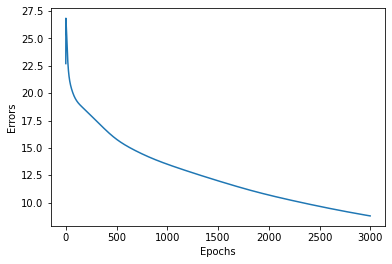

In [13]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.show()
    
plot_error(nn)

In [14]:
y_train_prediction = nn.predict(X_train)
y_test_prediction = nn.predict(X_test)
y_prediction = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [15]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[104   8   0   1   0   2   2   0]
 [  0 109   1   1   0   2   0   0]
 [  9   1  59   2   9   3   6   0]
 [  7   4   2  55   2  10   0  11]
 [  6   3   2   0  79   8   0   2]
 [  0   7   0   1   4  66   0   0]
 [  2   0   8   0   2   0  84   5]
 [  2   0   2   7   2   4   9  53]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       117
           1       0.83      0.96      0.89       113
           2       0.80      0.66      0.72        89
           3       0.82      0.60      0.70        91
           4       0.81      0.79      0.80       100
           5       0.69      0.85      0.76        78
           6       0.83      0.83      0.83       101
           7       0.75      0.67      0.71        79

    accuracy                           0.79       768
   macro avg       0.79      0.78      0.78       768
weighted avg       0.79      0.79      0.79       768



### Matrice de confusion ensemble "test"

In [16]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[20 11  0  1  0  4  1  1]
 [ 1 25  1  0  2  3  3  1]
 [ 5  0  7  6  2  1  2  2]
 [ 3  1  0 12  5 10  1  1]
 [ 3  0  1  1 13  4  1  0]
 [ 1  2  0  2  4 23  0  0]
 [ 1  1  3  3  2  0 20  2]
 [ 1  0  0  3  2  3  7  6]]
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        38
           1       0.62      0.69      0.66        36
           2       0.58      0.28      0.38        25
           3       0.43      0.36      0.39        33
           4       0.43      0.57      0.49        23
           5       0.48      0.72      0.57        32
           6       0.57      0.62      0.60        32
           7       0.46      0.27      0.34        22

    accuracy                           0.52       241
   macro avg       0.52      0.51      0.50       241
weighted avg       0.53      0.52      0.51       241



### Matrice de confusion ensemble "Val"

In [17]:
print(confusion_matrix(y_val,y_prediction))
print(classification_report(y_val,y_prediction))

[[ 4 20  0  3  0  1  1  0]
 [ 1 20  2  1  0  1  1  0]
 [ 0  0  0 11  1  2  0  2]
 [ 0  5  1  7  0  3  1  4]
 [ 0  8  0  4  2  7  2  1]
 [ 1 11  0  0  0  7  0  0]
 [ 4  3  0  6  1  1  6 10]
 [ 0  3  1  6  1  0  1 15]]
              precision    recall  f1-score   support

           0       0.40      0.14      0.21        29
           1       0.29      0.77      0.42        26
           2       0.00      0.00      0.00        16
           3       0.18      0.33      0.24        21
           4       0.40      0.08      0.14        24
           5       0.32      0.37      0.34        19
           6       0.50      0.19      0.28        31
           7       0.47      0.56      0.51        27

    accuracy                           0.32       193
   macro avg       0.32      0.31      0.27       193
weighted avg       0.35      0.32      0.28       193



## Support Vector Machine (SVM lineair)

In [18]:
svc = SVC(cache_size=1500)
parameter = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10], 'class_weight': ['balanced'], 'gamma': ['scale']}
classifier = GridSearchCV(svc, param_grid = parameter, cv = 10, n_jobs = 5, scoring = 'accuracy', verbose=4)
classifier.fit(X_train, y_train)
print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (classifier.best_params_, classifier.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.58


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    1.1s finished


Nous avons constaté qu'augmenter la grosseur de la cache ne changeait pas nos résultats, alors nous l'avons gardé à 1500.

In [19]:
SVMaccuracy = pd.DataFrame(classifier.cv_results_['mean_test_score'], index = [x['C'] for x  in classifier.cv_results_['params']], columns = ['SVM accuracy'])
print(SVMaccuracy)

        SVM accuracy
0.001       0.106801
0.100       0.376111
1.000       0.475239
10.000      0.575444


## K-Nearest Neighbor (KNN)

In [20]:
# K-Nearest Neighbor 
def KNN_model (X_train, X_test, y_train, y_test, weights):
    
    KNN_accuracy_uniform = []
    KNN_f1_uniform = []
    
    KNNParams = [3,5,10]

    for neighbors in KNNParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
        KNNmodel = model.fit(X_train, y_train)
        y_prediction = KNNmodel.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_prediction)
        f1score = f1_score(y_test, y_prediction, average = 'weighted') 

        KNN_accuracy_uniform.append(accuracy)
        KNN_f1_uniform.append(f1score)
        
        # F1 Score
        print("F1 score : KNN")
        print(f1_score(y_test, y_prediction, average = 'weighted'))
        
        # Accuracy Score
        print("Accuracy score : KNN avec k = " + str(neighbors) + " et poid = " + weights)
        print(KNNmodel.score(X_test, y_test))
        
        clf  = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
        
        ## KNN - Cross-validation
        print("Cross-validation")
        KNN_scores = cross_val_score(clf , X, y, cv = 10)
        print(sum(KNN_scores) / 10)
        print('\n')

In [21]:
KNN_model(X_train, X_test, y_train, y_test, 'uniform')
KNN_model(X_train, X_test, y_train, y_test, 'distance')

F1 score : KNN
0.5195635429009499
Accuracy score : KNN avec k = 3 et poid = uniform
0.5269709543568465
Cross-validation
0.6314256198347108


F1 score : KNN
0.5241143234806538
Accuracy score : KNN avec k = 5 et poid = uniform
0.5311203319502075
Cross-validation
0.6514531680440772


F1 score : KNN
0.5208469274891031
Accuracy score : KNN avec k = 10 et poid = uniform
0.5269709543568465
Cross-validation
0.6664118457300275


F1 score : KNN
0.531946370003502
Accuracy score : KNN avec k = 3 et poid = distance
0.5394190871369294
Cross-validation
0.6314256198347108


F1 score : KNN
0.4966300981399362
Accuracy score : KNN avec k = 5 et poid = distance
0.5020746887966805
Cross-validation
0.6514531680440772


F1 score : KNN
0.5242831153269478
Accuracy score : KNN avec k = 10 et poid = distance
0.5269709543568465
Cross-validation
0.6664118457300275




## Réseaux de neurones (RN)

In [22]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [23]:
y_test_prediction = mlp.predict(X_test)
y_train_prediction = mlp.predict(X_train)
y_prediction = mlp.predict(X_val)

### Matrice de confusion ensemble "train"

In [24]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[  0   0   0  12 104   0   1   0]
 [  2   1   0  11  99   0   0   0]
 [  0   0   0   9  79   0   1   0]
 [  1   0   0  13  73   0   4   0]
 [  1   0   0   9  89   0   1   0]
 [  2   0   0   1  75   0   0   0]
 [  0   0   0  52  29   0  20   0]
 [  0   0   0  30  33   0  16   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       1.00      0.01      0.02       113
           2       0.00      0.00      0.00        89
           3       0.09      0.14      0.11        91
           4       0.15      0.89      0.26       100
           5       0.00      0.00      0.00        78
           6       0.47      0.20      0.28       101
           7       0.00      0.00      0.00        79

    accuracy                           0.16       768
   macro avg       0.21      0.15      0.08       768
weighted avg       0.24      0.16      0.09       768



C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matrice de confusion ensemble "test"

In [25]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[ 0  0  0  6 32  0  0  0]
 [ 2  1  0  2 30  0  1  0]
 [ 2  0  0  1 19  0  3  0]
 [ 0  0  0 11 22  0  0  0]
 [ 0  0  0  2 21  0  0  0]
 [ 0  0  0  1 31  0  0  0]
 [ 2  0  0  8  7  0 15  0]
 [ 0  0  0  6 10  0  6  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       1.00      0.03      0.05        36
           2       0.00      0.00      0.00        25
           3       0.30      0.33      0.31        33
           4       0.12      0.91      0.22        23
           5       0.00      0.00      0.00        32
           6       0.60      0.47      0.53        32
           7       0.00      0.00      0.00        22

    accuracy                           0.20       241
   macro avg       0.25      0.22      0.14       241
weighted avg       0.28      0.20      0.14       241



## Conclusion et intreprétation des résultats

Pour conclure, nous avons réussi à faire un modèle d'apprentissage machine en fonction des notions vue en cours. Nous avons remarqué que , dépendament du models, les hyperparamètres peuvent  varié et avoir des effets differents. Cela nous démontre l'importance de choisir un bon modèle en fonction dude la situation qu'on veut résoudre, car un mauvais choix de modèle peut s'avérer catastrophique. Ce laboratoire nous a permis d'appliquer nos nouvelles connaissances vue en classe et de les approfondirs. Il nous a aussi permi d'apprendre l'importance d'un bon choix pour les modèles sélectionner en fonction de la situation et l'importance d'une bonne décision face aux hyperparamètres.